# Apply GBDT on Final Data

In [1]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import os
import warnings
warnings.filterwarnings('ignore')

### Steps: 
1. Create Train, Test and CV sets such that the class distribution is balanced 
2. Use test_df to create Test and CV sets
3. Create a custom implementation of RandomSearchCV where you feed the Train set for training and CV set for cross validation
4. Select the set of hyperparameter values which yield the best performance
5. Build the best model using above values and evaluate the performance on Test set.

### Approach: 
1. Split the df_train into 2 parts -> df_train0 and df_train1 which consists of records of classed 0 and 1 respectively
2. Randomly select 100000 rows from df_train0 and df_train1
3. Concat the dataframes together
4. Repeat the same for df_test (select 50000 rows at random from df_test0 and df_test1 and concat)
5. Create a Stratified Split from test data to get cv data.

In [2]:
%%time
df_train = pd.read_hdf('saved_after_fea/storage_stage6.h5', 'train_df',mode='r')
df_train0 = df_train[df_train['indicator_link']==0].reset_index(drop=True)
df_train1 = df_train[df_train['indicator_link']==1].reset_index(drop=True)

CPU times: user 43 s, sys: 10.1 s, total: 53.1 s
Wall time: 53.1 s


In [6]:
%%time
df_test = pd.read_hdf('saved_after_fea/storage_stage6.h5', 'test_df',mode='r')
df_test0 = df_test[df_test['indicator_link']==0].reset_index(drop=True)
df_test1 = df_test[df_test['indicator_link']==1].reset_index(drop=True)

CPU times: user 10.7 s, sys: 2.53 s, total: 13.2 s
Wall time: 13.2 s


Note: We build our model using a sample of data and so we use the random module to select random rows from train_df and test_df

In [3]:
import random
n_train =  7550015 #size of df_train0/df_train1
s = 100000 #desired sample size
select_rows_train = sorted(random.sample(range(0,n_train),s)) #indices of rows that we want to skip

n_test = 1887504 #size of df_test0/df_test1
s = 50000 #desired sample size
select_rows_test = sorted(random.sample(range(0,n_test),s)) #indices of rows that we want to skip

In [4]:
df_train0 = df_train0.iloc[select_rows_train,:]
df_train1 = df_train1.iloc[select_rows_train,:]
df_train = pd.concat([df_train0, df_train1], ignore_index=True)

In [7]:
df_test0 = df_test0.iloc[select_rows_test,:]
df_test1 = df_test1.iloc[select_rows_test,:]
df_test = pd.concat([df_test0, df_test1], ignore_index=True)

In [8]:
df_train.shape, df_test.shape

((200000, 59), (100000, 59))

In [14]:
X_train = df_train.drop(columns=['source_node', 'destination_node','indicator_link'])
y_train = df_train['indicator_link']

X_test = df_test.drop(columns=['source_node', 'destination_node','indicator_link'])
y_test = df_test['indicator_link']

In [15]:
from sklearn.model_selection import train_test_split
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size = 0.5, stratify=y_test, random_state=42)

In [18]:
print('Class Distribution in Train:\n',y_train.value_counts(normalize=True),
      '\nClass Distribution in Test:\n',y_test.value_counts(normalize=True),
     '\nClass Distribution in CV:\n',y_cv.value_counts(normalize=True))

Class Distribution in Train:
 0    0.5
1    0.5
Name: indicator_link, dtype: float64 
Class Distribution in Test:
 0    0.5
1    0.5
Name: indicator_link, dtype: float64 
Class Distribution in CV:
 0    0.5
1    0.5
Name: indicator_link, dtype: float64


# Building an LGBM Classifier 
- We use LGBM instead of XGBoost because LightGBM performs faster and keeps memory usage to low

In [37]:
def batch_predict(clf, data):
    #store the probability values in the below list
    y_prob = []
    
    rem = data.shape[0]%1000
    loop = data.shape[0] - rem
    for i in range(0, loop, 1000):
        y_prob.extend(clf.predict_proba(data[i:1000+i])[:,1]) #[:, 1] gives all values in column 1 that represents project approved
    
    #predict the probabilities for remaining rows
    if rem!=0:
        y_prob.extend(clf.predict_proba(data[loop:])[:,1])
    return y_prob

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [26]:
#set seed for reproducibility
random.seed(15)

n_iter = 10 
params = {'n_estimators':[100, 250, 500, 1000, 2000],'colsample_bytree':[0.2,0.3,0.4,0.5,0.6],'max_depth':[5,8,10,12,15], 
          'subsample': [0.3, 0.4, 0.5, 0.6], 'min_child_weight':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
          'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

#this dict stores the parameter values selected at each iteration 
selected_params = {'n_estimators':[],'colsample_bytree':[], 'max_depth':[], 'subsample': [], 
                   'min_child_weight':[], 'learning_rate':[]}

#the below lists store the f1 scores at each iteration 
train_scores = []
cv_scores = []

for i in range(1,n_iter+1):
    #use random.choice to select random values for each parameter from params dict
    #append the values to selected_params dict
    for k,v in list(params.items()):
        selected_params[k].append(random.choice(v))
    
    #use the selected values to build the classifier
    #fit the classifier on train set
    lgbm_rand = LGBMClassifier(n_estimators = selected_params['n_estimators'][-1], colsample_bytree = selected_params['colsample_bytree'][-1],
                               max_depth = selected_params['max_depth'][-1], subsample = selected_params['subsample'][-1], 
                               min_child_weight = selected_params['min_child_weight'][-1], learning_rate = selected_params['learning_rate'][-1]
                               ,objective = 'binary', n_jobs=-1, random_state = 42)
    lgbm_rand.fit(X_train,y_train)
    
    #get predicted values for train and cv sets
    y_train_pred = lgbm_rand.predict(X_train)
    y_cv_pred = lgbm_rand.predict(X_cv)
    
    #compute the f1 scores and store them in lists
    train_scores.append(f1_score(y_train,y_train_pred))
    cv_scores.append(f1_score(y_cv,y_cv_pred))
    
    #print the scores 
    print(f'Iteration {i} Scores:', '\nTrain Score:', train_scores[-1], ', CV Score:', cv_scores[-1])

Iteration 1 Scores: 
Train Score: 0.9681322264302376 , CV Score: 0.8783167993023002
Iteration 2 Scores: 
Train Score: 0.9302025361490179 , CV Score: 0.8668374706654897
Iteration 3 Scores: 
Train Score: 0.9890691982571025 , CV Score: 0.9275792598876047
Iteration 4 Scores: 
Train Score: 0.9767423080029073 , CV Score: 0.8932390554755358
Iteration 5 Scores: 
Train Score: 0.9972863365543483 , CV Score: 0.9112719128225008
Iteration 6 Scores: 
Train Score: 0.9904260820234253 , CV Score: 0.8941300019690638
Iteration 7 Scores: 
Train Score: 0.971163967611336 , CV Score: 0.929926116151304
Iteration 8 Scores: 
Train Score: 0.9794784117329621 , CV Score: 0.8889863205892669
Iteration 9 Scores: 
Train Score: 0.9655895739972198 , CV Score: 0.8774421187898853
Iteration 10 Scores: 
Train Score: 0.9849462149189451 , CV Score: 0.9139572788882216


Clearly, the model at iteration 7 yields the best cv scores so we evaluate that model on our test set.

In [29]:
#selecting the parameter values that yield the best results 
best_params = {}
for k in selected_params.keys():
    best_params[k] = selected_params[k][6]

In [30]:
best_params

{'n_estimators': 1000,
 'colsample_bytree': 0.6,
 'max_depth': 10,
 'subsample': 0.6,
 'min_child_weight': 0.2,
 'learning_rate': 0.001}

In [32]:
best_n_estimators = best_params['n_estimators']
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_colsample_bytree = best_params['colsample_bytree']
best_subsample = best_params['subsample']
best_min_child_weight = best_params['min_child_weight']

lgbm_best_params = LGBMClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, colsample_bytree = best_colsample_bytree, 
                                  subsample = best_subsample, learning_rate = best_learning_rate, min_child_weight = best_min_child_weight, 
                                  objective = 'binary', n_jobs=-1,random_state = 42)
lgbm_best_params.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.001, max_depth=10,
               min_child_weight=0.2, n_estimators=1000, objective='binary',
               random_state=42, subsample=0.6)

In [33]:
#get predicted values for train and test sets
y_train_pred = lgbm_best_params.predict(X_train)
y_test_pred = lgbm_best_params.predict(X_test)

# Performance of Model

### Primary Metric : F1 Score

In [34]:
from sklearn.metrics import f1_score
print('Train F1 Score',f1_score(y_train,y_train_pred))
print('Test F1 Score',f1_score(y_test,y_test_pred))

Train F1 Score 0.971163967611336
Test F1 Score 0.9321016166281755


### Confusion, Precision and Recall Matrices

Performance on Train represented through Matrices:


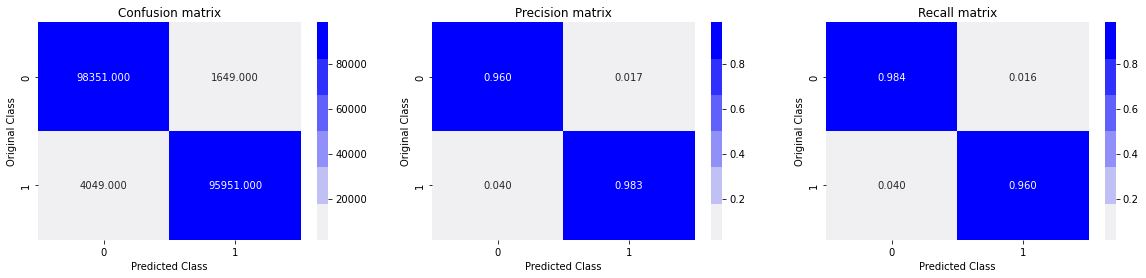

Performance on Test represented through Matrices:


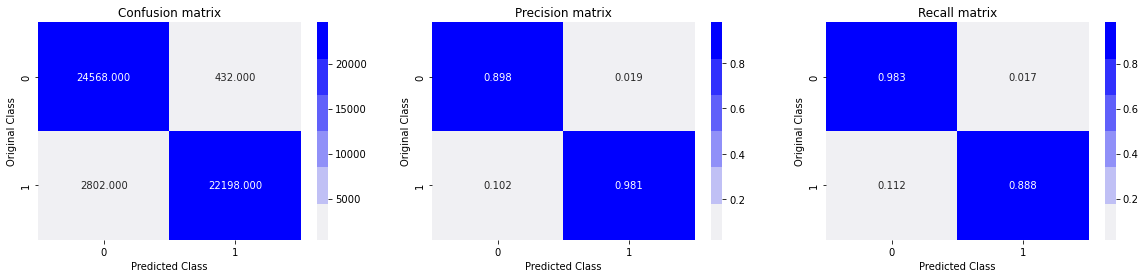

In [35]:
print('Performance on Train represented through Matrices:')
plot_confusion_matrix(y_train,y_train_pred)
print('Performance on Test represented through Matrices:')
plot_confusion_matrix(y_test,y_test_pred)

### ROC AUC Score

In [38]:
from sklearn.metrics import roc_curve, auc

#y_train_prob and y_test_prob are both list of probabilities of a directed edge being present labeled by 1 
y_train_prob = batch_predict(lgbm_best_params, X_train)
y_test_prob = batch_predict(lgbm_best_params, X_test)

#roc_curve takes different thresholds of probability every time to separate classes then calculates tpr and fpr for each threshold
#tpr and fpr values are then used in plotting the roc curve 
#the area under roc curve depicts the potential of a model at predicting classes if given an optimal threshold
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_prob)

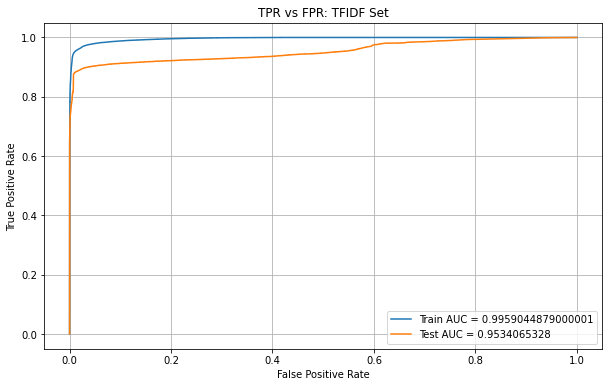

In [39]:
# Plot the ROC curves using the probability predictions made on train and test data.
plt.figure(figsize=(10,6))

plt.plot(train_fpr, train_tpr, label='Train AUC = '+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC = '+str(auc(test_fpr, test_tpr)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TPR vs FPR: TFIDF Set")
plt.legend()
plt.grid()
plt.show()

# Summary

In [40]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Hyperparams", "F1", "AUC"]
x.add_rows(
    [
        ["LightGBM", 6, 0.93, 0.95]
     
    ]
)

print(x)

+----------+-------------+------+------+
|  Model   | Hyperparams |  F1  | AUC  |
+----------+-------------+------+------+
| LightGBM |      6      | 0.93 | 0.95 |
+----------+-------------+------+------+
